# Multinetwork storage optimization with PandaModels.jl
This tutorial describes how to run a storage optimization over multiple timesteps with a PandaModels.jl multinetwork
together with pandapower.

To run a storage optimization over multiple time steps, the power system data is copied n_timestep times internally.
This is done efficiently in a julia script. Each network in the multinetwork dict represents a single time step. 
The input time series must be written to the loads and generators accordingly to each network. 
This is currently done by converting input time series to pandapwower controllers, saving it together with the grid data as a json file and loading the data back in julia. This "hack" is probably just a temporary solution. 

Some notes:
* only storages which are set as "controllable" are optimized
* time series can be written to load / sgen elements
* output of the optimization is a dict containing pandas DataFrames for every optimized storage and time step   

For more details on PowerModels (PandaModels) storage model see:

https://lanl-ansi.github.io/PowerModels.jl/stable/storage/ and 
https://github.com/e2nIEE/PandaModels.jl/blob/develop/src/models/call_powermodels.jl

For more details on PowerModels multinetworks see:

https://lanl-ansi.github.io/PowerModels.jl/stable/multi-networks/


# Installation
You need the standard Julia, PowerModels, Ipopt and JuMP Installation (see the opf_powermodels.ipynb).
 

# Run the storage optimization
In order to start the optimization and visualize results, we follow four steps:
1) Load the pandapower grid data (here the cigre MV grid)
2) Convert the time series to pandapwoer-controllers
3) Start the optimization
4) Get and plot the results


## 1) Get the grid data
We load the cigre medium voltage grid with "pv" and "wind" generators. Also we set some limits and add a storage with
**controllable** == True


In [1]:
import pandas as pd
from pandapower.networks.cigre_networks import create_cigre_network_mv
from pandapower.create import create_storage
from pandapower.runpm import runpm_storage_opf, read_pm_storage_results
from pandapower.control import ConstControl
from pandapower.timeseries import DFData

In [2]:
def cigre_grid():
    net = create_cigre_network_mv("pv_wind")
    # set some limits
    min_vm_pu = 0.95
    max_vm_pu = 1.05

    net["bus"].loc[:, "min_vm_pu"] = min_vm_pu
    net["bus"].loc[:, "max_vm_pu"] = max_vm_pu

    net["line"].loc[:, "max_loading_percent"] = 100.

    # close all switches
    net.switch.loc[:, "closed"] = True
    # add storage to bus 10
    create_storage(net, 10, p_mw=0.5, max_e_mwh=.2, soc_percent=0., q_mvar=0., controllable=True)

    return net

## 2) Convert the time series to pandapower-controllers
The following functions loads the example time series from the input_file and scales the power accordingly.
It then adds the time series data to the grid model by creating controllers.


In [3]:
def convert_timeseries_to_controller(net, input_file):
    
    # set the load type in the cigre grid, since it is not specified
    net["load"].loc[:, "type"] = "residential"
    
    # set the sgen type in the cigre grid
    net.sgen.loc[:, "type"] = "pv"
    net.sgen.loc[8, "type"] = "wind"

    # read the example time series
    time_series = pd.read_json(input_file)
    time_series.sort_index(inplace=True)

    # this example time series has a 15min resolution with 96 time steps for one day
    n_timesteps = time_series.shape[0]
    
    # get rated power
    load_p = net["load"].loc[:, "p_mw"].values
    sgen_p = net["sgen"].loc[:7, "p_mw"].values
    wind_p = net["sgen"].loc[8, "p_mw"]

    load_ts = pd.DataFrame(index=time_series.index.tolist(), columns=net.load.index.tolist())
    sgen_ts = pd.DataFrame(index=time_series.index.tolist(), columns=net.sgen.index.tolist())
    sgen_cols = sgen_ts.columns
    for t in range(n_timesteps):
        load_ts.loc[t] = load_p * time_series.at[t, "residential"]
        sgen_ts.loc[t, sgen_cols[:8]] = sgen_p * time_series.at[t, "pv"]
        sgen_ts.loc[t, sgen_cols[8]] = wind_p * time_series.at[t, "wind"]

    # create time series controller for load and sgen 
    ConstControl(net, element="load", variable="p_mw",
                 element_index=net.load.index.tolist(), profile_name=net.load.index.tolist(),
                 data_source=DFData(load_ts))
    ConstControl(net, element="sgen", variable="p_mw",
                 element_index=net.sgen.index.tolist(), profile_name=net.sgen.index.tolist(),
                 data_source=DFData(sgen_ts))

## 3) Start the optimization 
Before we start the optimization, we create the grid and controller, adding the time series in 15min resolution. 


In [4]:
# open the cigre mv grid
net = cigre_grid()

# convert the time series to pandapower controller
input_file = "cigre_timeseries_15min.json"
convert_timeseries_to_controller(net, input_file)

Now, the time series is added through (const) controllers, and you can check the created controllers


In [5]:
print("--- time series controller:", net.controller)

print("--- considered element of controller 0:", net.controller.object[0].__dict__["matching_params"]["element"])
print("--- considered element index of controller 0:",net.controller.object[0].__dict__["matching_params"]["element_index"])
print("--- time series data:",net.controller.object[0].data_source.df)


--- time series controller:                      object  in_service  order level  initial_run  \
0  ConstControl [load.p_mw]        True   -1.0    -1        False   
1  ConstControl [sgen.p_mw]        True   -1.0    -1        False   

                                          recycle  name  
0  {'trafo': False, 'gen': False, 'bus_pq': True}  None  
1  {'trafo': False, 'gen': False, 'bus_pq': True}  None  
--- considered element of controller 0: load
--- considered element index of controller 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
--- time series data:           0         1         2         3         4         5         6   \
0   3.838794  0.070777  0.110512  0.186256  0.140313  0.150247  0.121687   
1   3.731032   0.06879   0.10741  0.181027  0.136374  0.146029  0.118271   
2   3.178328    0.0586  0.091498  0.154211  0.116172  0.124397  0.100751   
3   3.026164  0.055795  0.087118  0.146828   0.11061  0.118441  0.095927   
4   3.136205  0.057823  0.090286  

We start the optimization for timesteps from 0 to 10.


In [ ]:
# run the optimization for the first ten timesteps (the first run can be slow).
try:
    runpm_storage_opf(net, from_time_step=0, to_time_step=10, pm_mip_solver='cbc')
except Exception as err:
    print(err)

## 4) Get and plot the results 
Get and plot the optimization results for the storage.


C:\git\pandapower\pandapower\opf\pm_storage.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  res_storage.at[t, "p_mw"] = pm_storage["ps"]
C:\git\pandapower\pandapower\opf\pm_storage.py:70: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  res_storage.at[t, "q_mvar"] = pm_storage["qs"]
C:\git\pandapower\pandapower\opf\pm_storage.py:71: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  res_storage.at[t, "soc_percent"] = pm_storage["se"] * 1e2
C:\git\pandapower\pandapower\opf\pm_storage.py:72: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  res_storage.at[t, "soc_mwh"] = pm_storage["se"] * \


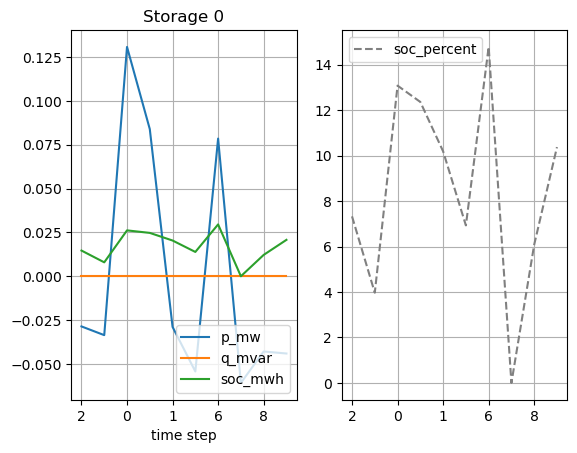

In [7]:
import matplotlib.pyplot as plt

def plot_storage_results(storage_results):
    n_res = len(storage_results.keys())
    fig, axes = plt.subplots(n_res, 2)
    if n_res == 1:
        axes = [axes]
    for i, (key, val) in enumerate(storage_results.items()):
        res = val
        axes[i][0].set_title("Storage {}".format(key))
        el = res.loc[:, ["p_mw", "q_mvar", "soc_mwh"]]
        el.plot(ax=axes[i][0])
        axes[i][0].set_xlabel("time step")
        axes[i][0].legend(loc=4)
        axes[i][0].grid()
        ax2 = axes[i][1]
        patch = plt.plot([], [], ms=8, ls="--", mec=None, color="grey", label="{:s}".format("soc_percent"))
        ax2.legend(handles=patch)
        ax2.set_label("SOC percent")
        res.loc[:, "soc_percent"].plot(ax=ax2, linestyle="--", color="grey")
        ax2.grid()
    plt.show()

# get the results
storage_results = read_pm_storage_results(net)
    
# plot the results
plot_storage_results(storage_results)